In [1]:
from dask.distributed import Client

client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 16.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:62528,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 16.00 GiB
Comm: tcp://127.0.0.1:62539,Total threads: 2
Dashboard: http://127.0.0.1:62542/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:62531,


In [2]:
from tabascal.dask.observation import Observation
# from tabascal.jax.observation import Observation
from tabascal.utils.tools import (
    generate_random_sky, 
    beam_size, 
    load_antennas
)

import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 16

n_time = 450
n_ant = 64
n_int_samples = 128

n_src = 10
mean_I = 0.1

start_time = 440
int_time = 2.

times = start_time + int_time * jnp.arange(n_time)

freqs = jnp.linspace(886e6, 1768e6, 16)
# freqs = jnp.linspace(886e6, 1768e6, 1)

SEFD = 420.

n_sat = 1

RFI_amp_cal = 200.*0.29e-6*jnp.ones(len(freqs))
el, inclination, lon_asc_node, periapsis = 20200e3, 55.0, 21., 5.0
G0_mean = 1.0
G0_std = 0.0#5
Gt_std_amp = 0.#1e-5
Gt_std_phase = jnp.deg2rad(1e-3)

rng = np.random.default_rng(12345)
ENU = rng.permutation(load_antennas('MeerKAT'))

# Create Target Observation Data
tar = Observation(latitude=-30., longitude=21., elevation=1050., 
                  ra=27., dec=15., times=times, freqs=freqs, SEFD=SEFD,
                  ENU_array=ENU[:n_ant], n_int_samples=n_int_samples, 
                  max_chunk_MB=100)

trgt_I, d_ra, d_dec = generate_random_sky(n_src, mean_I, tar.freqs, fov=tar.fov, beam_width=tar.syn_bw)

tar.addAstro(I=trgt_I, ra=tar.ra+d_ra, dec=tar.dec+d_dec)

tar.addSatelliteRFI(Pv=RFI_amp_cal, elevation=el, inclination=inclination,
                    lon_asc_node=lon_asc_node, periapsis=periapsis)

tar.addStationaryRFI(Pv=1.e-3*jnp.ones((1,tar.n_freq)), latitude=jnp.array([-20.]), longitude=jnp.array([23.]), elevation=jnp.array([tar.elevation]))
# tar.addStationaryRFI(Pv=2.e-4*jnp.ones((1,tar.n_freq)), latitude=jnp.array([-20.]), longitude=jnp.array([31.]), elevation=jnp.array([tar.elevation]))
# tar.addStationaryRFI(Pv=2.e-3*jnp.ones((1,tar.n_freq)), latitude=jnp.array([-20.]), longitude=jnp.array([31.]), elevation=jnp.array([tar.elevation]))

tar.addGains(G0_mean=G0_mean, G0_std=G0_std, Gt_std_amp=Gt_std_amp, Gt_std_phase=Gt_std_phase)
tar.calculate_vis()

# save_observations()

<xarray.Dataset>
Dimensions:           (time: 450, bl: 2016, freq: 16, time_fine: 57600,
                       ant: 64, enu: 3, xyz: 3, uvw: 3, ast_src: 10, lmn: 3,
                       radec: 2, sat_src: 1, orbit: 4, stat_src: 1, geo: 3)
Coordinates:
  * time              (time) float64 440.0 442.0 444.0 ... 1.336e+03 1.338e+03
  * time_fine         (time_fine) float64 439.0 439.0 ... 1.339e+03 1.339e+03
  * freq              (freq) float64 8.86e+08 9.448e+08 ... 1.709e+09 1.768e+09
  * bl                (bl) int64 0 1 2 3 4 5 6 ... 2010 2011 2012 2013 2014 2015
  * ant               (ant) int64 0 1 2 3 4 5 6 7 8 ... 56 57 58 59 60 61 62 63
  * uvw               (uvw) <U1 'u' 'v' 'w'
  * lmn               (lmn) <U1 'l' 'm' 'n'
  * xyz               (xyz) <U1 'x' 'y' 'z'
  * enu               (enu) <U5 'east' 'north' 'up'
  * radec             (radec) <U3 'ra' 'dec'
  * geo               (geo) <U9 'latitude' 'longitude' 'elevation'
Dimensions without coordinates: ast_src, sat_src, orbit, stat_src
Data variables: (12/24)
    vis_obs           (time, bl, freq) complex128 dask.array<chunksize=(6, 2016, 4), meta=np.ndarray>
    vis_ast           (time_fine, bl, freq) complex128 dask.array<chunksize=(768, 2016, 4), meta=np.ndarray>
    vis_rfi           (time_fine, bl, freq) complex128 dask.array<chunksize=(768, 2016, 4), meta=np.ndarray>
    antenna1          (bl) int64 dask.array<chunksize=(2016,), meta=jaxlib.xla_extension.Array>
    antenna2          (bl) int64 dask.array<chunksize=(2016,), meta=jaxlib.xla_extension.Array>
    ants_enu          (ant, enu) float64 dask.array<chunksize=(64, 3), meta=np.ndarray>
    ...                ...
    rfi_sat_ang_sep   (sat_src, time_fine, ant) float64 dask.array<chunksize=(1, 768, 64), meta=np.ndarray>
    rfi_sat_orbit     (sat_src, orbit) float64 dask.array<chunksize=(1, 1), meta=np.ndarray>
    rfi_stat_A        (stat_src, time_fine, ant, freq) float64 dask.array<chunksize=(1, 768, 64, 4), meta=np.ndarray>
    rfi_stat_xyz      (stat_src, time_fine, xyz) float64 dask.array<chunksize=(1, 768, 3), meta=np.ndarray>
    rfi_stat_ang_sep  (stat_src, time_fine, ant) float64 dask.array<chunksize=(1, 768, 64), meta=np.ndarray>
    rfi_stat_geo      (stat_src, geo) float64 dask.array<chunksize=(1, 1), meta=np.ndarray>
Attributes: (12/18)
    tel_name:       MeerKAT
    tel_latitude:   -30.0
    tel_longitude:  21.0
    tel_elevation:  1050.0
    target_ra:      27.0
    target_dec:     15.0
    ...             ...
    n_time:         450
    n_time_fine:    57600
    n_int_samples:  128
    n_sat_src:      1
    n_stat_src:     1
    n_ast_src:      10

In [149]:
tar.vis_obs

dask.array<add, shape=(450, 2016, 16), dtype=complex128, chunksize=(450, 2016, 1), chunktype=numpy.ndarray>

In [150]:
tar.vis_ast

dask.array<add, shape=(57600, 2016, 16), dtype=complex128, chunksize=(1280, 2016, 1), chunktype=numpy.ndarray>

In [5]:
tar.vis_rfi

dask.array<add, shape=(57600, 2016, 1), dtype=complex128, chunksize=(1280, 2016, 1), chunktype=numpy.ndarray>

In [7]:
%timeit -r 3 vis_obs = tar.vis_obs.compute()

22.7 s ± 344 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


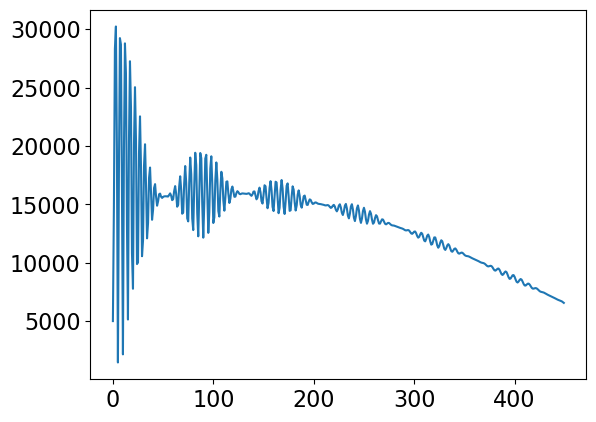

In [27]:
plt.plot(jnp.abs(vis_obs[:,0,:]));

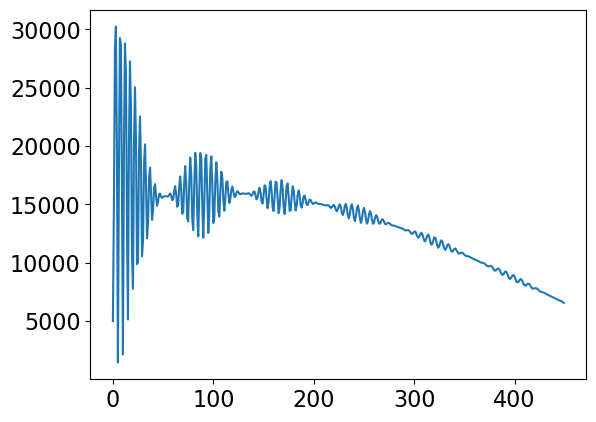

In [5]:
plt.plot(jnp.abs(vis_obs[:,0,:]));

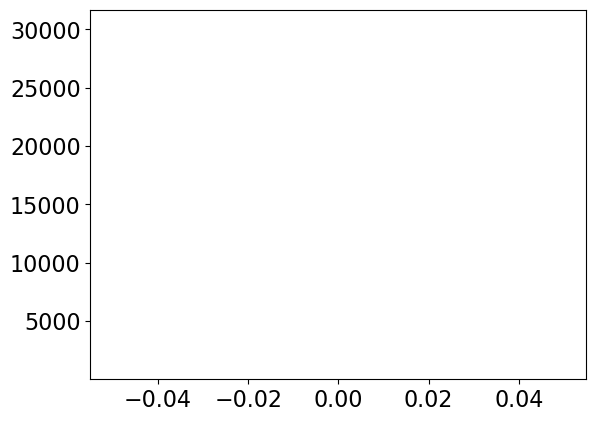

In [6]:
plt.plot(jnp.abs(vis_obs[:,0,:].T));

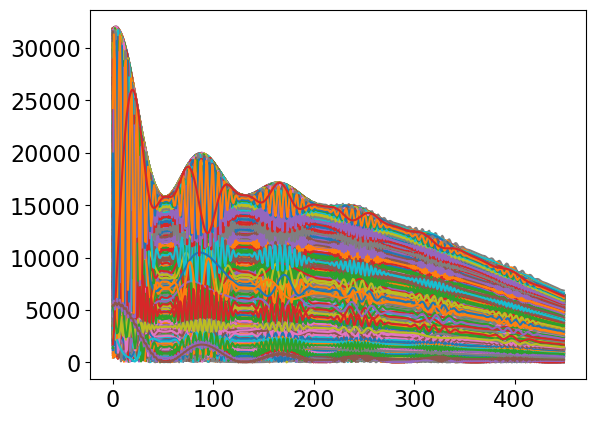

In [10]:
plt.plot(jnp.abs(vis_obs[:,:,0]));

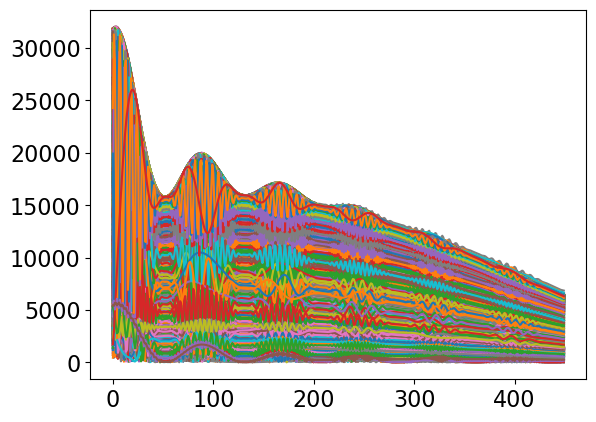

In [7]:
plt.plot(jnp.abs(vis_obs[:,:,0]));

In [7]:
vis_obs.shape

(450, 2016, 16)

In [22]:
import dask.array as da
import xarray as xr
import numpy as np

In [57]:
data = {
        "vis_obs": (["time", "bl", "freq"], tar.vis_obs),
        "vis_ast": (["time_fine", "bl", "freq"], tar.vis_ast),
       }

data_opt = {
        "vis_rfi": (["time_fine", "bl", "freq"], tar.vis_rfi),
    
        "ants_uvw": (["time_fine", "ant", "uvw"], tar.ants_uvw),
        "bl_uvw": (["time_fine", "bl", "uvw"], tar.bl_uvw),
    
        "antenna1": (["bl"], tar.a1),
        "antenna2": (["bl"], tar.a2),
    
        "ants_enu": (["ant", "enu"], tar.ENU),
        "ants_xyz": (["time_fine", "ant", "xyz"], tar.ants_xyz),
    
        "SEFD": (["freq"], tar.SEFD),
        "noise_std": (["freq"], tar.noise_std),
        "noise_data": (["time", "bl", "freq"], tar.noise_data),
    
        "gains_ants": (["time_fine", "ant", "freq"], tar.gains_ants),
        "gains_bl": (["time_fine", "bl", "freq"], tar.gains_bl),
    
        # "ast_radec": (["ast_src", "radec"], tar.ast_radec),
        # "ast_I": (["ast_src"], tar.ast_I),
    
        # "rfi_sat_orbit": (["sat_src", "orbit"], tar.rfi_orbit),
        #

}

coords = {
          "time": tar.times,
          "time_fine": tar.times_fine,
          "bl": np.arange(tar.n_bl),
          "ant": np.arange(tar.n_ant),
          "freq": tar.freqs, 
          "uvw": np.array(["u", "v", "w"]),
          "xyz": np.array(["x", "y", "z"]),
          "enu": np.array(["east", "north", "up"]),
          "radec": np.array(["ra", "dec"]),
         }

attrs = {
         "tel_latitude": tar.latitude,
         "tel_longitude": tar.longitude,
         "tel_elevation": tar.elevation,
         "target_ra": tar.ra,
         "target_dec": tar.dec,
         "n_ant": tar.n_ant, 
         "n_freq": tar.n_freq,
         "n_bl": tar.n_bl,
         "n_time": tar.n_time,
         "n_time_fine": tar.n_time_fine,
         "n_int_samples": tar.n_int_samples,
    
        }

attrs = {key: value.compute() if type(value)==da.Array else value for key, value in attrs.items()}

data.update(data_opt)

ds = xr.Dataset(data, coords, attrs)

In [81]:
ds.attrs['n_ant']

64

In [86]:
ds.coords['time'].data

array([ 440.,  442.,  444.,  446.,  448.,  450.,  452.,  454.,  456.,
        458.,  460.,  462.,  464.,  466.,  468.,  470.,  472.,  474.,
        476.,  478.,  480.,  482.,  484.,  486.,  488.,  490.,  492.,
        494.,  496.,  498.,  500.,  502.,  504.,  506.,  508.,  510.,
        512.,  514.,  516.,  518.,  520.,  522.,  524.,  526.,  528.,
        530.,  532.,  534.,  536.,  538.,  540.,  542.,  544.,  546.,
        548.,  550.,  552.,  554.,  556.,  558.,  560.,  562.,  564.,
        566.,  568.,  570.,  572.,  574.,  576.,  578.,  580.,  582.,
        584.,  586.,  588.,  590.,  592.,  594.,  596.,  598.,  600.,
        602.,  604.,  606.,  608.,  610.,  612.,  614.,  616.,  618.,
        620.,  622.,  624.,  626.,  628.,  630.,  632.,  634.,  636.,
        638.,  640.,  642.,  644.,  646.,  648.,  650.,  652.,  654.,
        656.,  658.,  660.,  662.,  664.,  666.,  668.,  670.,  672.,
        674.,  676.,  678.,  680.,  682.,  684.,  686.,  688.,  690.,
        692.,  694.,

In [85]:
ds.SEFD.data

dask.array<open_dataset-fbba768fd6cac428f4f0b29fa368afc5SEFD, shape=(1,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>

In [56]:
ds.to_zarr("Observation")

In [61]:
ds1 = xr.open_zarr("Observation/")

In [62]:
ds1

<xarray.Dataset>
Dimensions:     (freq: 1, ant: 64, bl: 2016, enu: 3, time_fine: 57600, uvw: 3,
                 xyz: 3, time: 450, radec: 2)
Coordinates:
  * ant         (ant) int64 0 1 2 3 4 5 6 7 8 9 ... 55 56 57 58 59 60 61 62 63
  * bl          (bl) int64 0 1 2 3 4 5 6 ... 2009 2010 2011 2012 2013 2014 2015
  * enu         (enu) <U5 'east' 'north' 'up'
  * freq        (freq) float64 8.86e+08
  * radec       (radec) <U3 'ra' 'dec'
  * time        (time) float64 440.0 442.0 444.0 ... 1.336e+03 1.338e+03
  * time_fine   (time_fine) float64 439.0 439.0 439.0 ... 1.339e+03 1.339e+03
  * uvw         (uvw) <U1 'u' 'v' 'w'
  * xyz         (xyz) <U1 'x' 'y' 'z'
Data variables: (12/14)
    SEFD        (freq) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    antenna1    (bl) int64 dask.array<chunksize=(2016,), meta=np.ndarray>
    antenna2    (bl) int64 dask.array<chunksize=(2016,), meta=np.ndarray>
    ants_enu    (ant, enu) float64 dask.array<chunksize=(64, 3), meta=np.ndarray>
    ants_uvw    (time_fine, ant, uvw) float64 dask.array<chunksize=(1280, 64, 3), meta=np.ndarray>
    ants_xyz    (time_fine, ant, xyz) float64 dask.array<chunksize=(1280, 64, 3), meta=np.ndarray>
    ...          ...
    gains_bl    (time_fine, bl, freq) float64 dask.array<chunksize=(1280, 2016, 1), meta=np.ndarray>
    noise_data  (time, bl, freq) float64 dask.array<chunksize=(113, 504, 1), meta=np.ndarray>
    noise_std   (freq) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    vis_ast     (time_fine, bl, freq) complex128 dask.array<chunksize=(1280, 2016, 1), meta=np.ndarray>
    vis_obs     (time, bl, freq) complex128 dask.array<chunksize=(10, 2016, 1), meta=np.ndarray>
    vis_rfi     (time_fine, bl, freq) complex128 dask.array<chunksize=(1280, 2016, 1), meta=np.ndarray>
Attributes:
    n_ant:          64
    n_bl:           2016
    n_freq:         1
    n_int_samples:  128
    n_time:         450
    n_time_fine:    57600
    target_dec:     15.0
    target_ra:      27.0
    tel_elevation:  1050.0
    tel_latitude:   -30.0
    tel_longitude:  21.0

# Fringe Frequency and Stationary RFI Sources

In [ ]:
trgt_I.shape

In [ ]:
plt.plot(trgt_I.T)#.sum(axis=1));

In [ ]:
for a in tar.rfi_A_app.values():
    plt.plot(a[:,:,0])

In [ ]:
tar.vis_obs.shape

In [ ]:
plt.plot(jnp.abs(tar.vis_obs[:,0,0]))

In [11]:
from tabascal.interferometry import airy_beam

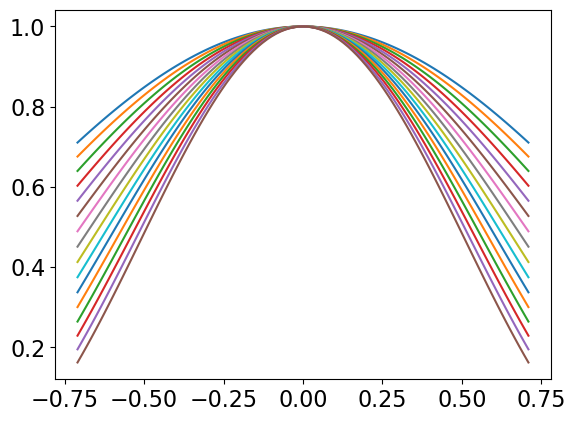

In [17]:
degs = jnp.linspace(-tar.fov, tar.fov, 101)
plt.plot(degs, airy_beam(degs[:,None,None], tar.freqs, tar.dish_d)[:,0,0,:]);

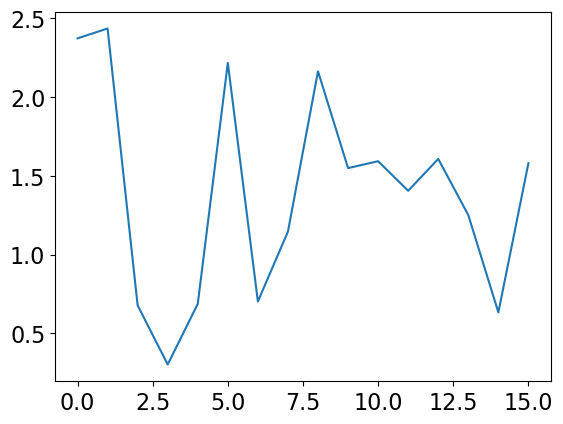

In [9]:
plt.plot(jnp.abs(tar.vis_obs[0,0,:].compute()))

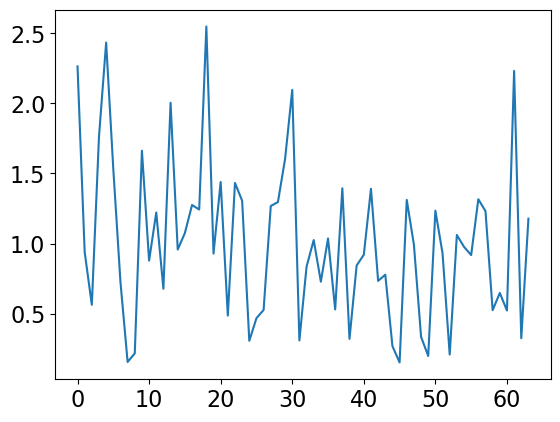

In [23]:
plt.plot(jnp.abs(tar.vis_obs[0,0,:]))

In [17]:
jnp.argmax(jnp.linalg.norm(tar.bl_uvw[0], axis=-1))

Array(4, dtype=int64)

In [6]:
jnp.argmin(jnp.linalg.norm(tar.bl_uvw[0], axis=-1))

Array(35, dtype=int64)

In [10]:
from tabascal.coordinates import T_s

bl = 21
bl = 35

c = 2.99792458e8
lam = (c/(tar.freqs))
lam

omega_e = (2*jnp.pi)**2/T_s

rfi_phase = jnp.unwrap(jnp.angle(tar.vis_rfi[:,bl,0]))
rfi_phase -= rfi_phase[0]
rfi_fringe = jnp.diff(rfi_phase)/jnp.diff(tar.times_fine)

fringe_phase = 2*jnp.pi*tar.bl_uvw[:,bl,-1]/lam
fringe_phase -= fringe_phase[0]
fringe = jnp.diff(fringe_phase)/jnp.diff(tar.times_fine)

fringe2 = -omega_e*tar.bl_uvw[:,bl,0]/lam * jnp.cos(jnp.deg2rad(tar.dec))

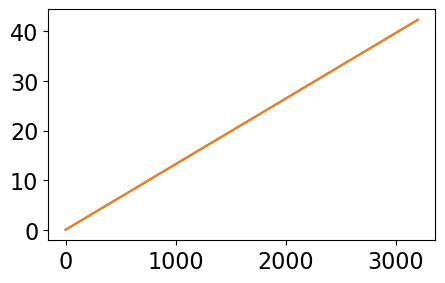

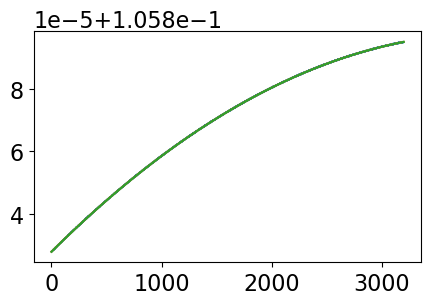

In [11]:
plt.figure(figsize=(5,3))

plt.plot(rfi_phase)
plt.plot(fringe_phase)

plt.figure(figsize=(5,3))

plt.plot(rfi_fringe)
plt.plot(fringe)
plt.plot(fringe2)

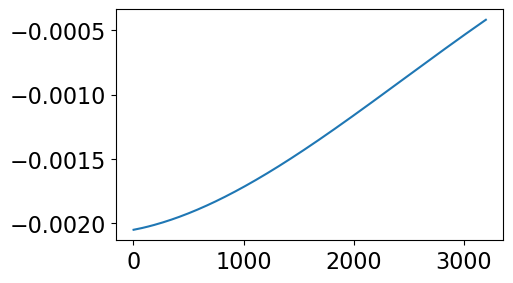

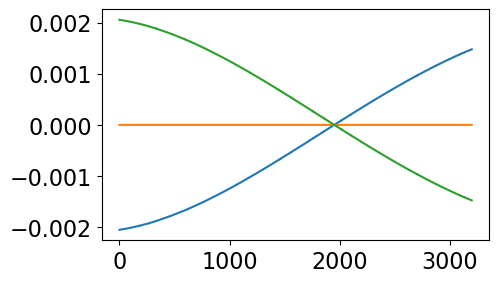

In [119]:
plt.figure(figsize=(5,3))

plt.plot(rfi_phase/fringe_phase - 1)

plt.figure(figsize=(5,3))

plt.plot(rfi_fringe/fringe - 1)
plt.plot(fringe/fringe2[:-1] - 1)
plt.plot(fringe2[:-1]/rfi_fringe - 1)

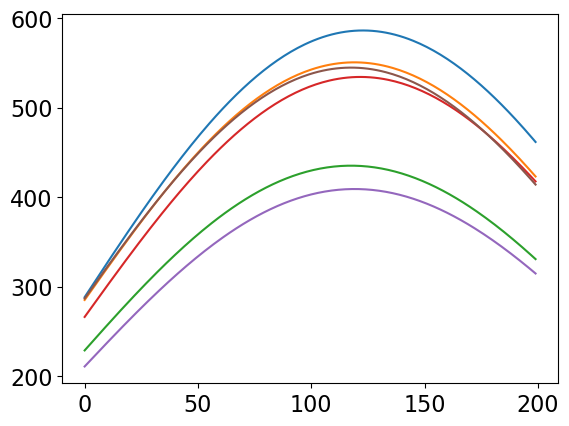

In [9]:
plt.plot(jnp.abs(tar.vis_obs[:,:,0]));

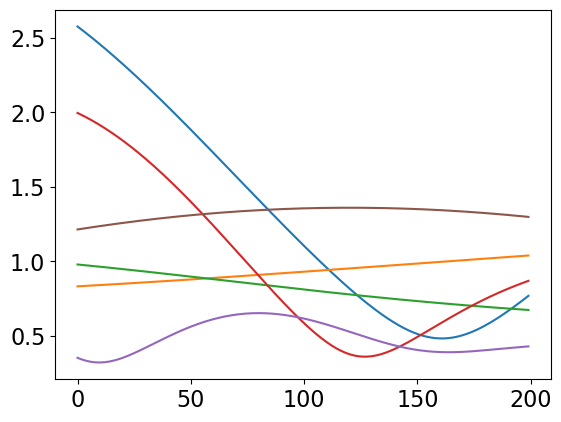

In [10]:
plt.plot(jnp.abs(tar.vis_ast[:,:,0].reshape(tar.n_time,tar.n_int_samples,-1).mean(axis=1)));

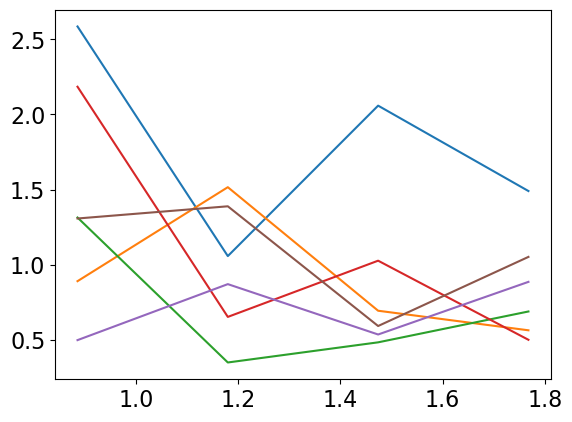

In [82]:
plt.plot(tar.freqs/1e9, jnp.abs(tar.vis_ast[0,:,:].T));

In [4]:
jnp.array([jnp.array([-31., 1, 2]), jnp.array([-31., 2, 3])]).shape

(2, 3)

In [7]:
save_observations('./test_obs', [tar,])

In [8]:
tar.ast_I.shape

(100, 128)

Text(0.5, 0, 'Frequency [GHz]')

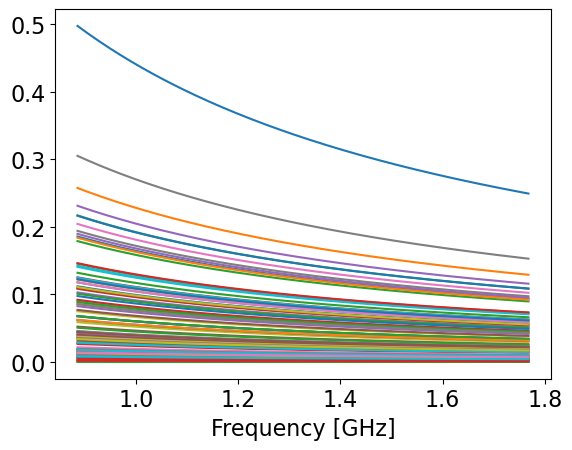

In [9]:
plt.plot(tar.freqs/1e9, tar.ast_I.T)
plt.xlabel('Frequency [GHz]')

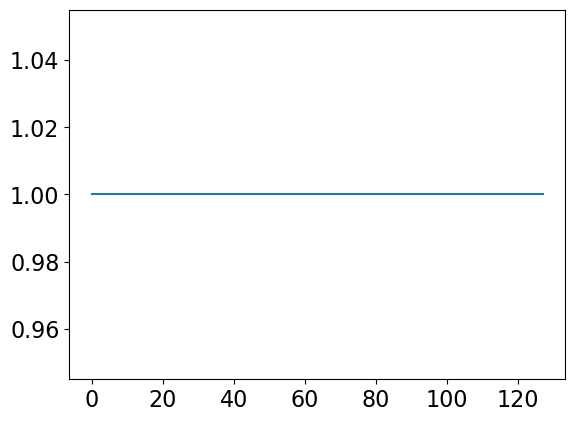

In [10]:
plt.plot(jnp.abs(tar.gains_bl[0,0,:]))

Text(0.5, 0, 'Frequency [GHz]')

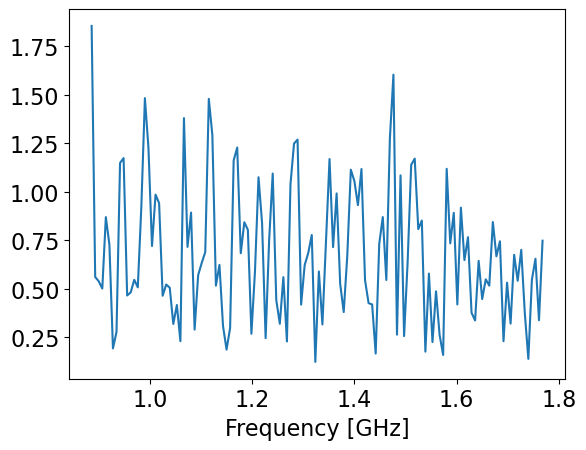

In [11]:
plt.plot(tar.freqs/1e9, jnp.abs(tar.vis_ast[0,0,:]))
plt.xlabel('Frequency [GHz]')